# [Project] 교통 표지판 이미지 분류

---

## 프로젝트 목표
- 교통 표지판 이미지 데이터를 분석하고 딥러딩 모델을 통하여 표지판 종류를 예측하는 분류 모델 수행
- 대량의 이미지 데이터를 전 처리하는 과정과 이에 따른 CNN 모델의 성능 변화를 학습

---

## 프로젝트 목차
1. **데이터 분석:** 이미지 데이터를 이루고 있는 요소에 대해서 Dataframe를 사용하여 분석 및 확인

2. **데이터 전 처리:** 이미지 데이터를 읽어오고 딥러닝 모델의 입력으로 전 처리

3. **딥러닝 모델:** CNN 모델을 구현하고 학습, 평가 및 예측을 수행

---

## 데이터 출처
-  https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

---

## 프로젝트 개요

차량 운전을 하면서 도로 교통 표지판을 보고 규칙을 지키는 것은 운전자의 및 교통 안전을 위해서 중요한 일입니다. 만일 사람이 아닌 기계가 이를 수행해야 한다면, 어떻게 표지판을 구분할 수 있을까요? 이러한 물음은 자율 주행차 기술이 발전하면서 중요한 이슈가 되었고, 딥러닝 기술 바탕의 분류 모델이 상당한 수준의 정확도를 보이며 적용되고 있습니다.

이번 프로젝트에서는 교통 표지판 분류의 첫 번째 스텝으로 간단하게 교통 표지판 이미지가 입력 되었을 때 이 것이 43 종의 표지판 중 어떤 것인가를 분류하는 딥러닝 모델을 구현합니다. 이를 통하여 교통 표지판 이미지 데이터들의 특징과 CNN 모델을 통하여 분류를 수행하는 것을 학습할 수 있습니다. 

---

In [ ]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import VGG16


%matplotlib inline

In [ ]:
## GPU 사용시
## GPU 메모리 사용 크기만 할당

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. 데이터 분석

### 1-1. 이미지 데이터 정보 파악하기

이미지 데이터를 읽어오기 위해서 `./data` 에 어떠한 파일들이 존재 하는지 확인해 봅시다.

In [ ]:
DATA_PATH = './drive/MyDrive/SBA_data/data/'

In [ ]:
file_list = os.listdir(DATA_PATH)
file_list

['Meta.csv', 'Test.csv', 'Train.csv', 'Train', 'Test', 'Meta']

#### Meta

3개 폴더와 3개 csv 파일 포함. 
일반적으로 이미지 데이터의 csv 파일 제공시, 해당 이미지 디렉토리 정보 이용, 데이터 처리
csv 파일을 dataframe으로 읽어보기

In [ ]:
df_Meta = pd.read_csv(DATA_PATH + 'Meta.csv') # 디렉토리 경로 + 파일명
df_Meta.tail(), df_Meta.shape  # 43개의 클래스(표지판 종류)로 구성

(          Path  ClassId  ShapeId  ColorId SignId
 38  Meta/5.png        5        1        0   3.29
 39  Meta/6.png        6        1        3    3.3
 40  Meta/7.png        7        1        0   3.29
 41  Meta/8.png        8        1        0   3.29
 42  Meta/9.png        9        1        0   3.25, (43, 5))

`Meta.csv`는 Meta 폴더 내의 이미지에 대한 정보를 담고 있습니다. 위정보를 바탕으로 이미지를 출력해봅시다.

In [ ]:
print(len(df_Meta))

43


In [ ]:
df_Meta['ClassId'][42]

9

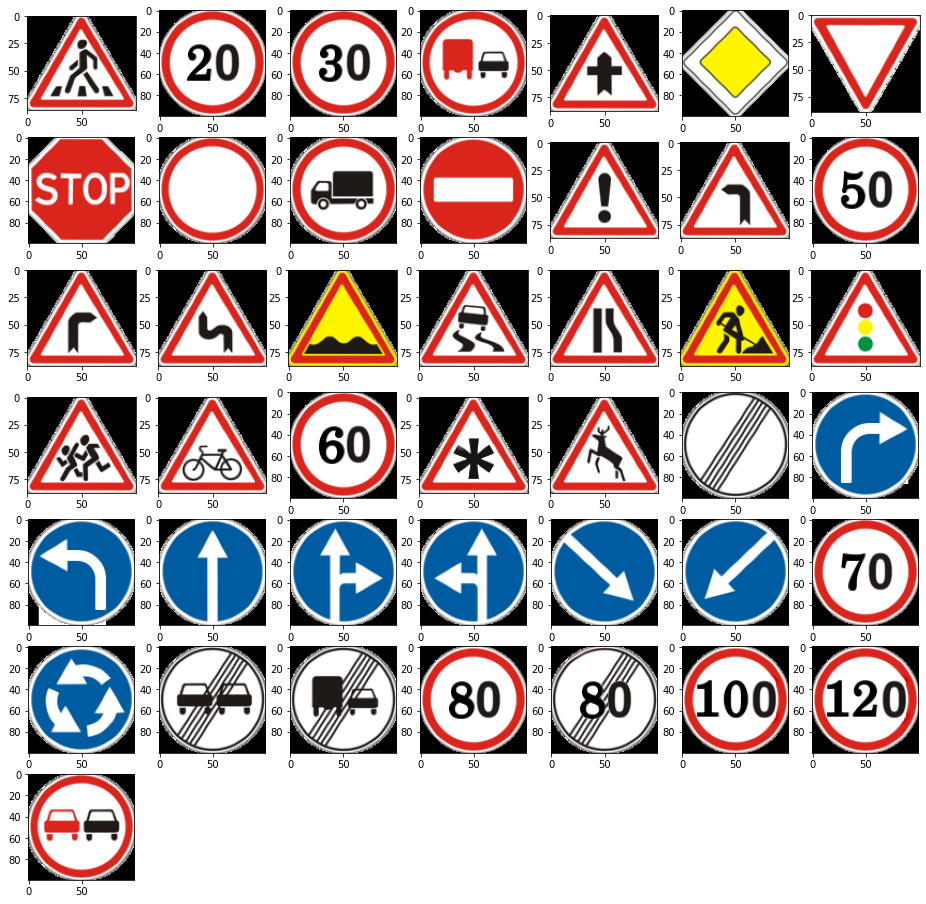

In [ ]:
Meta_images = []
Meta_labels = []

plt.figure(figsize=(16,16))
for i in range(len(df_Meta)):  # len(df_Meta) : 43개 샘플 하나씩 확인하며 이미지와 레이블 저장
    img = load_img(DATA_PATH + df_Meta['Path'][i])
    plt.subplot(7, 7, i+1)
    plt.imshow(img)
    Meta_images.append(img)
    Meta_labels.append(df_Meta['ClassId']) # Meta_labels.append(df_Meta['ClassId'][i])와 동일

In [ ]:
# print(Meta_labels) 

#### Train

이번엔 `Train.csv`를 확인해 봅시다.

In [ ]:
df_Train = pd.read_csv(DATA_PATH + 'Train.csv')
df_Train
# df_Train.shape

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png
...,...,...,...,...,...,...,...,...
39204,52,56,5,6,47,51,42,Train/42/00042_00007_00025.png
39205,56,58,5,5,51,53,42,Train/42/00042_00007_00026.png
39206,58,62,5,6,53,57,42,Train/42/00042_00007_00027.png
39207,63,69,5,7,58,63,42,Train/42/00042_00007_00028.png


39209개의 학습용 이미지 데이터 정보가 저장되어 있음

이러한 이미지 정보 중에 먼저 `Width`와 `Height`에 대해서 알아봅시다.

`Width`,`Height` : 이미지의 폭과 높이 정보. 샘플마다 다양한 크기 분포
 -> 이미지마다 크기가 다르면 서로 다른 feature개수가 있는 것, 크기 통일해주는 전처리 필요.
    어떤 크기로 통일할지, 이미지 크기의 분포를 보고 판단 필요.

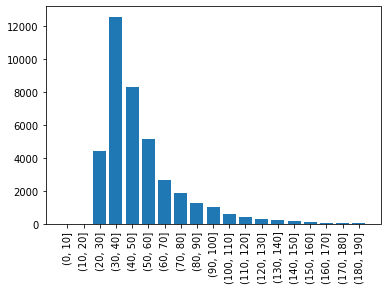

(0, 10]           0
(10, 20]          0
(20, 30]       4425
(30, 40]      12561
(40, 50]       8285
(50, 60]       5169
(60, 70]       2658
(70, 80]       1845
(80, 90]       1287
(90, 100]      1007
(100, 110]      598
(110, 120]      426
(120, 130]      298
(130, 140]      212
(140, 150]      165
(150, 160]       99
(160, 170]       70
(170, 180]       39
(180, 190]       21
Name: Width, dtype: int64

In [ ]:
dist = pd.cut(df_Train['Width'], np.arange(0,200,10)).value_counts(sort=False)
plt.bar(dist.index.astype(str), dist.values)
plt.xticks(rotation=90)
plt.show()

dist

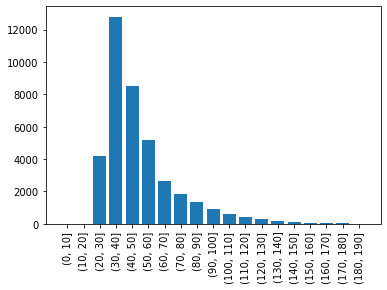

(0, 10]           0
(10, 20]          0
(20, 30]       4159
(30, 40]      12797
(40, 50]       8530
(50, 60]       5208
(60, 70]       2635
(70, 80]       1817
(80, 90]       1338
(90, 100]       937
(100, 110]      577
(110, 120]      405
(120, 130]      295
(130, 140]      188
(140, 150]      134
(150, 160]       80
(160, 170]       42
(170, 180]       32
(180, 190]        8
Name: Height, dtype: int64

In [ ]:
dist = pd.cut(df_Train['Height'], np.arange(0,200,10)).value_counts(sort=False)
plt.bar(dist.index.astype(str), dist.values)
plt.xticks(rotation=90)
plt.show()

dist

위 분포 보면 30~40(폭 또는 높이) 크기 이미지가 제일 많음. 
->이미지 크기 통일할때 너무 작은 크기는 큰 이미지의 정보손실, 반대로 큰 사이즈 선택시 작은 이미지의 정보량이 희석화 발생. 
-->적절한 이미지 크기 잡는 것은 하나의 파라미터 조정이 되며, 이번 프로젝트에서는 이미지 분포 기반으로 대다수를 차지하는 크기인 33x33 크기로 통일. (이후, 개인적인 실습에서 데이터 크기 조절에 따른 성능 변화를 살펴보는 것도 좋은 학습이 될 것입니다.)

In [ ]:
# ImageGenerator 설정을 위한 이미지 조정 크기 할당
image_height = 32
image_width = 32
image_channel = 3 # 컬러 이미지이기에 3채널

 이미지 데이터의 Roi(Region of interest)는 표지판이 있는 영역 의미.

`Train.csv`, `Test.csv` 파일의 Roi 데이터는 아래 실행 이미지에서 좌상 좌표와 우하 좌표 의미.

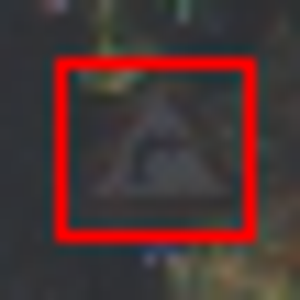

In [ ]:
from PIL import Image
from PIL import ImageDraw

img = Image.open(DATA_PATH + df_Train['Path'][0]) # 'Path': 이미지 파일별 이름 저장된 칼럼

draw = ImageDraw.Draw(img)
draw.rectangle([df_Train['Roi.X1'][0], df_Train['Roi.Y1'][0], 
                df_Train['Roi.X2'][0], df_Train['Roi.Y2'][0]], outline="red")
img_resized = img.resize((300,300))
img_resized

Roi 데이터를 사용하면 보다 명확하게 표지판 부분만을 crop 할 수 있으며, 이러한 데이터 전 처리를 통하여 분류의 성능을 높일 수 있습니다. (이번 프로젝트에서는 해당 전 처리를 생략합니다.)

#### Test

이번엔 `Test.csv`를 살펴보겠습니다.

In [ ]:
df_Test = pd.read_csv(DATA_PATH + 'Test.csv')
df_Test

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
...,...,...,...,...,...,...,...,...
12625,42,41,5,6,37,36,12,Test/12625.png
12626,50,51,6,5,45,46,33,Test/12626.png
12627,29,29,6,6,24,24,6,Test/12627.png
12628,48,49,5,6,43,44,7,Test/12628.png


Train.csv와 같은 형태로 구성되어 있는 것을 알 수 있습니다. test 데이터에 대해서는 분석하는 것은 표지판을 분류 하는 목적에 있어 큰 의미가 있지 않기에 이번 실습에서는 생략합니다.

## 2. 데이터 전 처리

### 2-1. 이미지 데이터 Generator 만들기

학습과 평가에 사용할 데이터 generator를 만들기. 

   1. 데이터를 전부 메모리에 불러오는 방법, 
   2. 폴더 지정 방법, 
   3. pandas의 DataFrame 이용한 방법 :  여기서는 DataFrame 이용 generator 생성

In [ ]:
df_Train.tail(3) # test 파일 저장 폴더와 구조 다름(아래 셀 비교)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
39206,58,62,5,6,53,57,42,Train/42/00042_00007_00027.png
39207,63,69,5,7,58,63,42,Train/42/00042_00007_00028.png
39208,68,69,7,6,62,63,42,Train/42/00042_00007_00029.png


In [ ]:
df_Test.tail(3)  # train 파일 저장 폴더와 구조 다름(위 셀)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
12627,29,29,6,6,24,24,6,Test/12627.png
12628,48,49,5,6,43,44,7,Test/12628.png
12629,32,31,6,5,27,26,10,Test/12629.png


#### Class (label) 값의 data type을 string으로 변경해야(텐서플로 특징)

In [ ]:
df_Train['ClassId'] = df_Train['ClassId'].astype(str)
df_Test['ClassId'] = df_Test['ClassId'].astype(str)

validation set을 만들기 위해, train set을 나눕니다. (Train: 60%, Valid: 40%)

In [ ]:
df_Train, df_Valid = train_test_split(df_Train, test_size=0.3,random_state=777 )

In [ ]:
df_Train   # 원본 데이터 크기의 60%만 훈련용으로 할당

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
704,31,32,5,6,26,27,1,Train/1/00001_00004_00014.png
27566,86,85,7,8,79,78,22,Train/22/00022_00008_00026.png
14551,29,26,6,5,24,21,9,Train/9/00009_00033_00001.png
33070,33,33,6,6,28,28,32,Train/32/00032_00007_00010.png
7813,37,36,6,5,32,31,4,Train/4/00004_00045_00013.png
...,...,...,...,...,...,...,...,...
28788,61,54,5,5,56,49,25,Train/25/00025_00010_00018.png
10879,59,58,6,5,54,53,7,Train/7/00007_00005_00019.png
26695,71,71,7,7,65,65,18,Train/18/00018_00037_00025.png
36785,27,28,5,5,22,23,38,Train/38/00038_00026_00006.png


In [ ]:
df_Valid

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
3940,52,54,5,6,46,49,2,Train/2/00002_00038_00010.png
23033,107,104,10,10,98,95,14,Train/14/00014_00013_00023.png
36749,29,29,5,5,24,24,38,Train/38/00038_00025_00000.png
3232,52,52,6,6,47,47,2,Train/2/00002_00014_00022.png
22089,81,74,8,6,73,68,13,Train/13/00013_00054_00009.png
...,...,...,...,...,...,...,...,...
9520,34,33,6,5,29,28,5,Train/5/00005_00036_00010.png
31930,39,39,5,6,34,34,30,Train/30/00030_00010_00010.png
1082,34,34,6,6,29,29,1,Train/1/00001_00017_00002.png
29434,29,27,6,6,23,22,25,Train/25/00025_00032_00004.png


DataFrame 이용 generator 생성. 
공통 argument를 미리 지정하고, 각 generator에서 필요한 argument는 각자 정의. 

ImageDataGenerator 생성하고 (여기서 Data Augmentation 설정 가능), 
후에 method인 flow_from_dataframe 이용해 iterator 생성.
Train, Validation, Test generator 들을 각각 생성.

In [ ]:
datagen_kwargs = dict(rescale=1./255)
dataflow_kwargs = dict(target_size=(image_height, image_width), 
                       batch_size=32,
                       directory=DATA_PATH, 
                       x_col='Path', 
                       y_col='ClassId' ,
                       class_mode='sparse',
                       interpolation='bilinear'
                      )

# Train
train_datagen = ImageDataGenerator(
#         shear_range=0.2,
         zoom_range=0.2,
         rotation_range=20,
         width_shift_range=0.2,
         height_shift_range=0.2,
         brightness_range=[0.25,1.0],
#         horizontal_flip=True,
    **datagen_kwargs
)

train_generator = train_datagen.flow_from_dataframe(
        df_Train, 
        **dataflow_kwargs
)

# Validation
valid_datagen = ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_dataframe(
    df_Valid, 
    shuffle=False, 
    **dataflow_kwargs
)

# Test
test_datagen = ImageDataGenerator(**datagen_kwargs)
test_generator = test_datagen.flow_from_dataframe(
    df_Test, 
    shuffle=False, 
    **dataflow_kwargs
)

Found 27446 validated image filenames belonging to 43 classes.
Found 11763 validated image filenames belonging to 43 classes.
Found 12630 validated image filenames belonging to 43 classes.


## 3. 딥러닝 모델

### 3-1. CNN 모델 설정

CNN을 사용하여 간단하게 모델을 구현해 보겠습니다. filters, kernel 등의 사이즈는 하이퍼 파리미터로 자신만의 모델로 튜닝이 가능합니다.

In [ ]:
# model = Sequential([
#     Input((image_height, image_width, image_channel)),
#     Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
#     MaxPool2D(pool_size=(2, 2)),
    
#     Conv2D(filters=64, kernel_size=3, activation='relu'),
#     MaxPool2D(pool_size=(2, 2)),
    
#     Flatten(),
#     Dense(512, activation='relu'),
#     Dropout(rate=0.25),
#     Dense(43, activation='softmax')
# ])

# model.summary()

In [ ]:
# vgg16 의 컨볼루션 레이어 구조 예시

# input = tf.keras.layers.Input(shape=(32,32,1))

# vgg_block01 = tf.keras.layers.Conv2D(64, (3,3), padding='SAME', activation='relu')(input)
# vgg_block1 = tf.keras.layers.Conv2D(64, (3,3), padding='SAME', activation='relu')(vgg_block01)
# vgg_block01 = tf.keras.layers.MaxPool2D((2,2))(vgg_block01) # 입력 이미지 크기의 절반으로 축소 32*32 --> 16*16*64 ; 64는 필터갯수


# vgg_block02 = tf.keras.layers.Conv2D(128, (3,3), padding='SAME', activation='relu')(vgg_block01)
# vgg_block02 = tf.keras.layers.Conv2D(128, (3,3), padding='SAME', activation='relu')(vgg_block02)
# vgg_block02 = tf.keras.layers.MaxPool2D((2,2))(vgg_block02) # 전 블록 이미지 크기의 1/2로 축소 16*16 --> 8*8*128 ; 128은 필터갯수


# vgg_block03 = tf.keras.layers.Conv2D(256, (3,3), padding='SAME', activation='relu')(vgg_block02)
# vgg_block03 = tf.keras.layers.Conv2D(256, (3,3), padding='SAME', activation='relu')(vgg_block03)
# vgg_block03 = tf.keras.layers.MaxPool2D((2,2))(vgg_block03) # 전 블록 이미지 크기의 1/2로 축소 8*8 --> 4*4*256 ; 256은 필터갯수


# vgg_block04 = tf.keras.layers.Conv2D(512, (3,3), padding='SAME', activation='relu')(vgg_block03)
# vgg_block04 = tf.keras.layers.Conv2D(512, (3,3), padding='SAME', activation='relu')(vgg_block04)
# vgg_block04 = tf.keras.layers.MaxPool2D((2,2))(vgg_block04) # 전 블록 이미지 크기의 1/2로 축소 4*4 --> 2*2*512 ; 512 필터갯수

# flatten = tf.keras.layers.Flatten()(vgg_block04) # 2048 차원 데이터 나옴
# dense01 = tf.keras.layers.Dense(512, activation='relu')(flatten) # flatten 아웃풋보다는 작은 크기로 할당이 일반적
# output = tf.keras.layers.Dense(43, activation='softmax')(dense01)


In [ ]:
model = Sequential([ 

Input((image_height, image_width, image_channel)),

#Conv2D(input_shape=(image_height, image_width, image_channel),filters=64,kernel_size=(3,3),padding="same", activation="relu"))

Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"),
MaxPool2D(pool_size=(2,2),strides=(2,2)),

Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
MaxPool2D(pool_size=(2,2),strides=(2,2)),

Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
MaxPool2D(pool_size=(2,2),strides=(2,2)),

Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
MaxPool2D(pool_size=(2,2),strides=(2,2)),

Flatten(),
Dense(units=300,activation="relu"),
Dropout(rate=0.10),
Dense(units=43, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         1

### 3-2. 학습 수행

43개의 class를 갖는 데이터이기에 loss 함수로 `sparse_categorical_crossentropy`을 설정하고 optimizer로는 SGD를 사용하여 학습하여 보겠습니다.

In [ ]:
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [ ]:
# 처음 만든 모델이라면 EPOCHS를 1~5개로 하여 잘 돌아가는지 
# 성능을 확인해보고 값을 증가 시켜 봅시다. 
EPOCHS =25

# EPOCHS에 따른 성능을 보기 위하여 history 사용
history = model.fit(
    train_generator,
    validation_data = valid_generator, # validation 데이터 사용
    epochs=EPOCHS, 
)

학습을 수행하면서 Accuracy와 Loss의 변화를 그래프로 출력하면 다음과 같습니다.

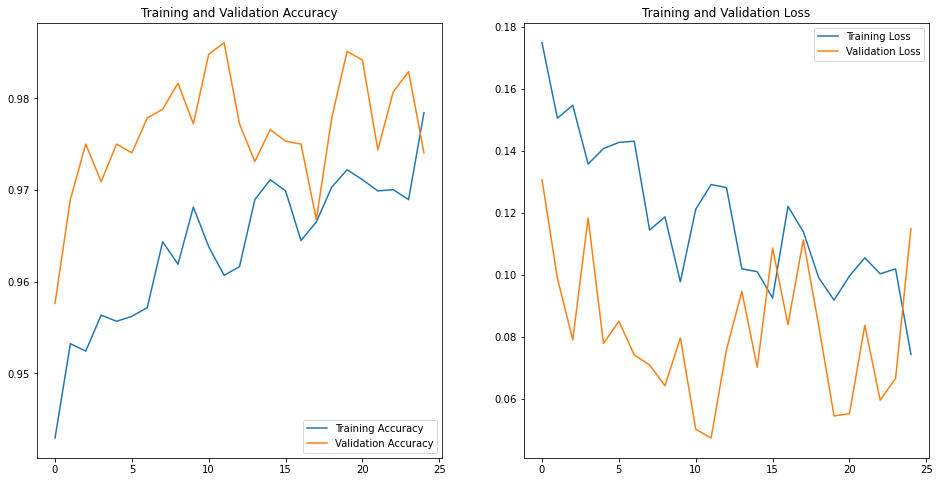

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 3-3. 모델 성능 평가 및 예측

학습이 잘 수행 되었으면 평가용 데이터에서 성능이 잘 나오는지 확인합니다.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)

print('test set accuracy: ', test_accuracy)

  ...
    to  
  ['...']
395/395 [==============================] - 12s 30ms/step - loss: 0.3791 - accuracy: 0.9316
test set accuracy:  0.93159145


이번엔 테스트 데이터를 입력하여 예측된 결과를 비교해 보겠습니다.

25개의 테스트 데이터를 불러와 실제 class와 예측 class를 출력하면 다음과 같습니다.

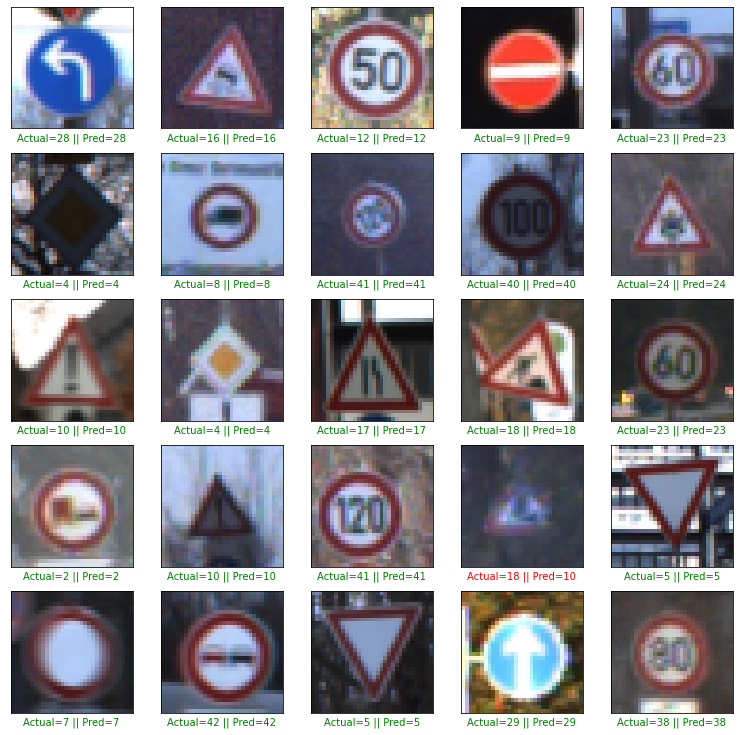

In [ ]:
plt.figure(figsize = (13, 13))
x_test, y_test = test_generator.next()
pred_test = model.predict_on_batch(x_test)
pred_class = np.argmax(pred_test, axis=-1)

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred_class[start_index + i]
    actual = int(y_test[start_index + i])
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(array_to_img(x_test[start_index + i]))
plt.show()

In [ ]:
test_prediction = model.predict(test_generator)
predicted_class = np.argmax(test_prediction, axis=-1)

마지막으로 confusion matrix를 시각화 하여 분류 학습 결과를 확인해봅니다.

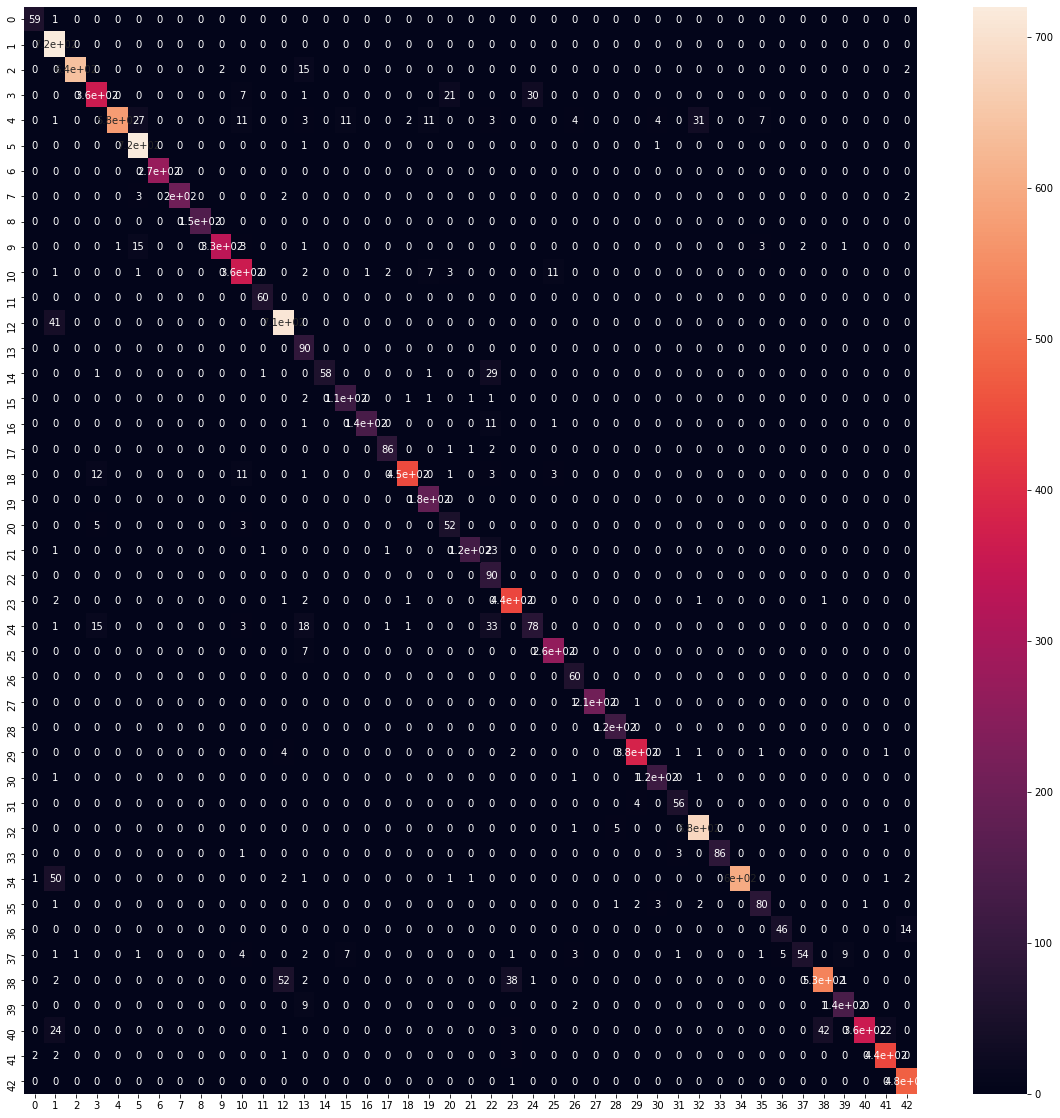

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_generator.labels, predicted_class)
plt.figure(figsize = (20, 20))
sns.heatmap(cm, annot = True)
plt.show()

---